In [1]:
# Import necessary modules first.
import tensorflow as tf
from tensorflow.keras.utils import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input
import numpy as np
import random
import matplotlib.pyplot as plt
import os 
import seaborn as sns
import warnings 
import PIL
from tqdm.notebook import tqdm 
warnings.filterwarnings('ignore')
%matplotlib inline
%matplotlib inline

In [2]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Search Dataset from Kaggle

In [3]:
!kaggle datasets list -s 'age,gender,ethnicity'

ref                                                             title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
nipunarora8/age-gender-and-ethnicity-face-data-csv              AGE, GENDER AND ETHNICITY (FACE DATA) CSV           63MB  2020-09-02 13:46:38          17162        287  1.0              
jangedoo/utkface-new                                            UTKFace                                            331MB  2018-08-16 19:05:30          19027        194  0.6875           
paultimothymooney/san-francisco-covid19-data                    San Francisco COVID-19 Data                         28KB  2022-10-09 19:04:20            207         20  0.9411765        
utkarshx27/smoking-dataset-from-uk                              S

# Download the dataset

In [4]:
!kaggle datasets download -d "jangedoo/utkface-new"

utkface-new.zip: Skipping, found more recently modified local copy (use --force to force download)


# Unzipping the dataset

In [5]:
import zipfile

In [6]:
with zipfile.ZipFile("utkface-new.zip","r") as file:
    file.extractall("age-gender")

In [7]:
import os

In [8]:
os.listdir("age-gender/UTKFace")

['100_0_0_20170112213500903.jpg.chip.jpg',
 '100_0_0_20170112215240346.jpg.chip.jpg',
 '100_1_0_20170110183726390.jpg.chip.jpg',
 '100_1_0_20170112213001988.jpg.chip.jpg',
 '100_1_0_20170112213303693.jpg.chip.jpg',
 '100_1_0_20170112215032192.jpg.chip.jpg',
 '100_1_0_20170117195420803.jpg.chip.jpg',
 '100_1_0_20170119212053665.jpg.chip.jpg',
 '100_1_2_20170105174847679.jpg.chip.jpg',
 '100_1_2_20170112213615815.jpg.chip.jpg',
 '100_1_2_20170112222336458.jpg.chip.jpg',
 '101_0_0_20170112213500903.jpg.chip.jpg',
 '101_1_2_20170105174739309.jpg.chip.jpg',
 '103_0_2_20170112213001988.jpg.chip.jpg',
 '105_0_0_20170112213001988.jpg.chip.jpg',
 '105_1_0_20170112213001988.jpg.chip.jpg',
 '105_1_0_20170112213021902.jpg.chip.jpg',
 '105_1_0_20170112213507183.jpg.chip.jpg',
 '105_1_1_20170112213303693.jpg.chip.jpg',
 '10_0_0_20161220222308131.jpg.chip.jpg',
 '10_0_0_20170103200329407.jpg.chip.jpg',
 '10_0_0_20170103200522151.jpg.chip.jpg',
 '10_0_0_20170103233459275.jpg.chip.jpg',
 '10_0_0_201701

# Read the dataset

In [9]:
BASE_DIR = 'age-gender/UTKFace'

In [10]:
age_labels = []
gender_labels = []
image_paths = []

image_filenames = os.listdir(BASE_DIR)
random.shuffle(image_filenames)

for image in tqdm(image_filenames):
  image_path = os.path.join(BASE_DIR, image)
  img_components = image.split('_')
  age_label = int(img_components[0])
  gender_label = int(img_components[1])

  # Append the image_path, age_label, and gender_label
  age_labels.append(age_label)
  gender_labels.append(gender_label)
  image_paths.append(image_path)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [11]:
print(f'Number of age_labels: {len(age_labels)}, Number of gender_labels: {len(gender_labels)}, Number of image_paths: {len(image_paths)}')


Number of age_labels: 23708, Number of gender_labels: 23708, Number of image_paths: 23708


In [12]:
gender_mapping = {
    1: 'Female',
    0: 'Male'
}

In [13]:
import pandas as pd 
df = pd.DataFrame()
df['image_path'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head(5)

,image_path,age,gender
0,age-gender/UTKFace\35_1_2_20170116183728469.jp...,35,1
1,age-gender/UTKFace\1_1_3_20161220145232550.jpg...,1,1
2,age-gender/UTKFace\18_0_0_20170110232054251.jp...,18,0
3,age-gender/UTKFace\8_0_0_20170110220129114.jpg...,8,0
4,age-gender/UTKFace\40_0_1_20170117141443985.jp...,40,0


# Exploratory Data Analysis

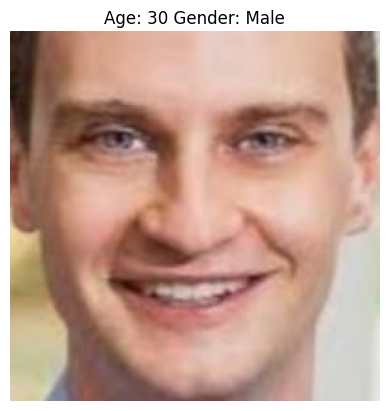

In [14]:
from PIL import Image

rand_index = random.randint(0, len(image_paths))
age = df['age'][rand_index]
gender = df['gender'][rand_index]
IMG = Image.open(df['image_path'][rand_index])
plt.title(f'Age: {age} Gender: {gender_mapping[gender]}')
plt.axis('off')
plt.imshow(IMG)

<Axes: xlabel='age', ylabel='Density'>

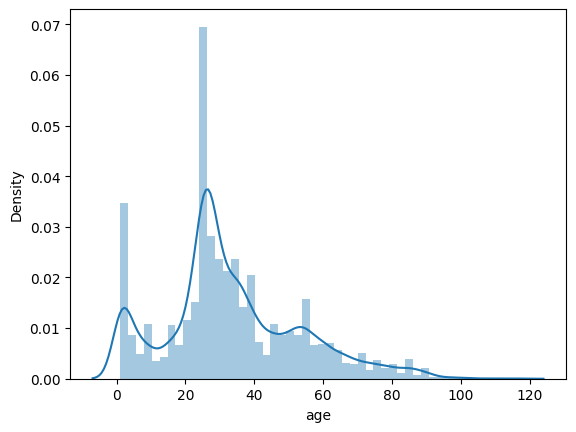

In [15]:
# Age distribution
sns.distplot(df['age'])

The distribution roughly follows a normal distribution that is slightly skewed to the right with a median of around 27 years. The range is from 0 to 120 years. There are some outliers at the higher end of the distribution.

<Axes: ylabel='count'>

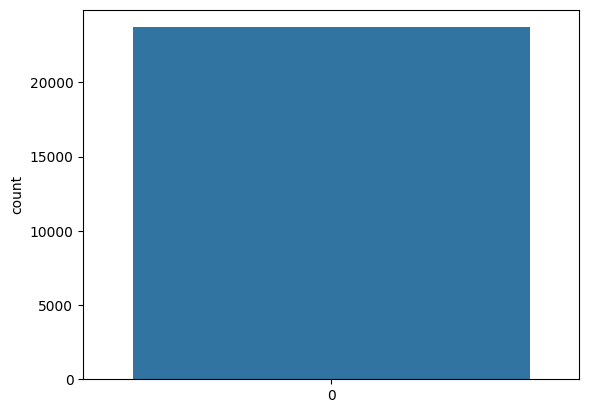

In [16]:
sns.countplot(df['gender'])

The number of samples for females are slightly higher than that of males. However, the dataset is not highly imbalanced.

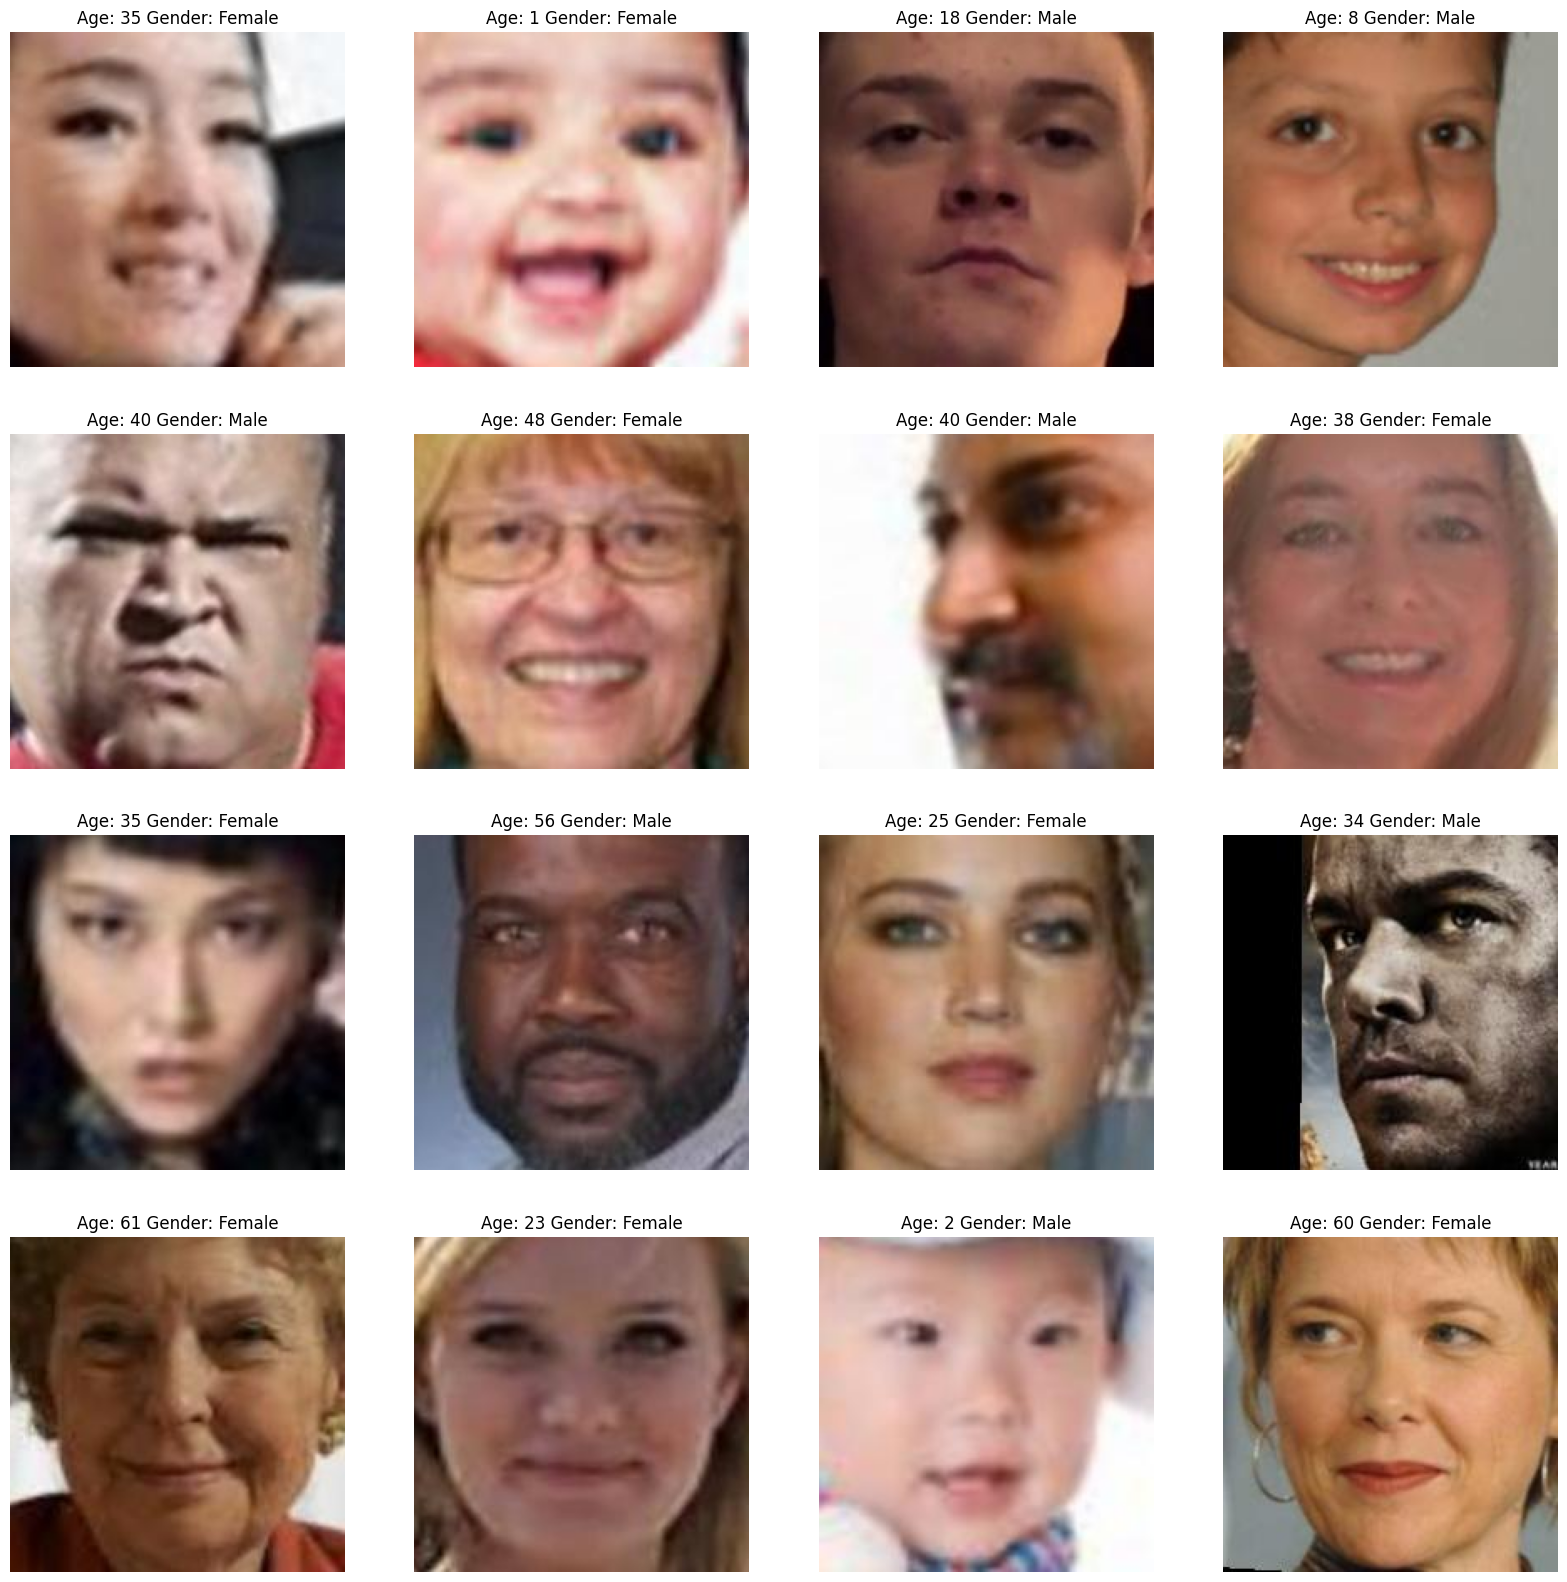

In [17]:
plt.figure(figsize=(20, 20))
samples = df.iloc[0:16]

for index, sample, age, gender in samples.itertuples():
    plt.subplot(4, 4, index + 1)
    img = load_img(sample)
    img = np.array(img)
    plt.axis('off')
    plt.title(f'Age: {age} Gender: {gender_mapping[gender]}')
    plt.imshow(img)


# Feature Extraction

In [18]:
def extract_image_features(images):
    features = list()

    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = img.resize((128, 128), PIL.Image.LANCZOS)
        img = np.array(img)
        features.append(img)

    features = np.array(features)
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [19]:
X = extract_image_features(df['image_path'])

  0%|          | 0/23708 [00:00<?, ?it/s]

In [20]:
X.shape

(23708, 128, 128, 1)

In [21]:
X = X / 255.0

In [22]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [23]:
input_shape = (128, 128, 1)

In [24]:
inputs = Input((input_shape))
# convolutional layers
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

flatten = Flatten() (maxp_4)

# fully connected layers
dense_1 = Dense(256, activation='relu') (flatten)
dense_2 = Dense(256, activation='relu') (flatten)

dropout_1 = Dropout(0.3) (dense_1)
dropout_2 = Dropout(0.3) (dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)
output_2 = Dense(1, activation='relu', name='age_out') (dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy'])

In [26]:
history = model.fit(x=X, y=[y_gender, y_age],
                    batch_size=32, epochs=50, validation_split=0.2)

Epoch 1/50
593/593 [==============================] - 343s 572ms/step - loss: 15.5238 - gender_out_loss: 0.6650 - age_out_loss: 14.8588 - gender_out_accuracy: 0.5941 - age_out_accuracy: 0.0469 - val_loss: 12.0930 - val_gender_out_loss: 0.5141 - val_age_out_loss: 11.5788 - val_gender_out_accuracy: 0.7474 - val_age_out_accuracy: 0.0409
Epoch 2/50
593/593 [==============================] - 319s 538ms/step - loss: 11.4529 - gender_out_loss: 0.4796 - age_out_loss: 10.9732 - gender_out_accuracy: 0.7659 - age_out_accuracy: 0.0371 - val_loss: 12.7819 - val_gender_out_loss: 0.4532 - val_age_out_loss: 12.3287 - val_gender_out_accuracy: 0.7978 - val_age_out_accuracy: 0.0291
Epoch 3/50
593/593 [==============================] - 314s 529ms/step - loss: 10.0299 - gender_out_loss: 0.4102 - age_out_loss: 9.6197 - gender_out_accuracy: 0.8089 - age_out_accuracy: 0.0265 - val_loss: 9.7248 - val_gender_out_loss: 0.3805 - val_age_out_loss: 9.3443 - val_gender_out_accuracy: 0.8216 - val_age_out_accuracy: 0.

Epoch 26/50
593/593 [==============================] - 306s 516ms/step - loss: 4.0803 - gender_out_loss: 0.0891 - age_out_loss: 3.9912 - gender_out_accuracy: 0.9636 - age_out_accuracy: 0.0459 - val_loss: 6.9998 - val_gender_out_loss: 0.3921 - val_age_out_loss: 6.6078 - val_gender_out_accuracy: 0.8908 - val_age_out_accuracy: 0.0462
Epoch 27/50
593/593 [==============================] - 311s 525ms/step - loss: 3.9305 - gender_out_loss: 0.0809 - age_out_loss: 3.8496 - gender_out_accuracy: 0.9673 - age_out_accuracy: 0.0455 - val_loss: 6.9816 - val_gender_out_loss: 0.3861 - val_age_out_loss: 6.5954 - val_gender_out_accuracy: 0.8895 - val_age_out_accuracy: 0.0456
Epoch 28/50
593/593 [==============================] - 304s 513ms/step - loss: 3.9054 - gender_out_loss: 0.0769 - age_out_loss: 3.8285 - gender_out_accuracy: 0.9690 - age_out_accuracy: 0.0458 - val_loss: 7.1614 - val_gender_out_loss: 0.5960 - val_age_out_loss: 6.5654 - val_gender_out_accuracy: 0.8728 - val_age_out_accuracy: 0.0460
E


# Plot the Results

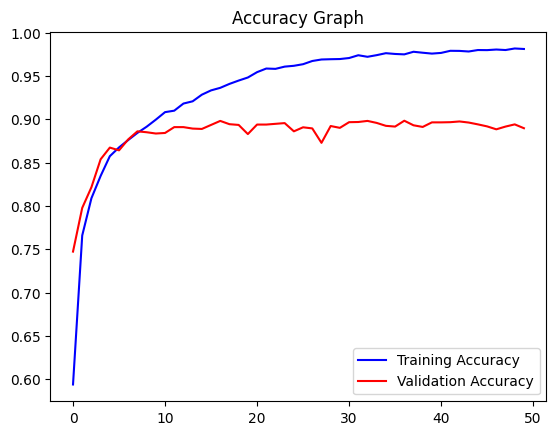

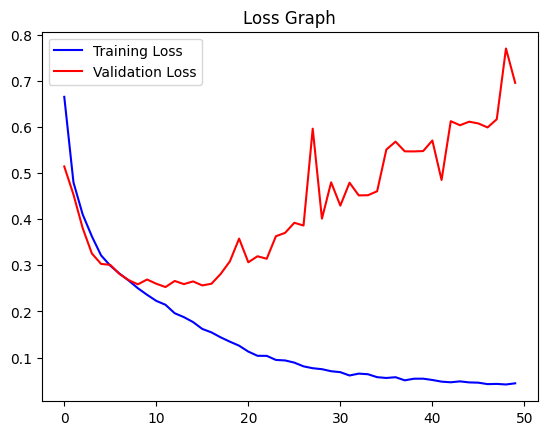

In [28]:
# plot results for gender
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['gender_out_loss']
val_loss = history.history['val_gender_out_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

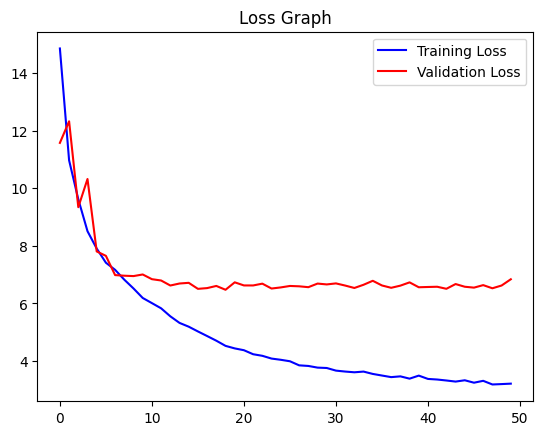

In [29]:
# plot results for age
loss = history.history['age_out_loss']
val_loss = history.history['val_age_out_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

# Predicting Test Data

Original Gender: Female Original Age: 37
1/1 [==============================] - 0s 280ms/step
Predicted Gender: Female Predicted Age: 37


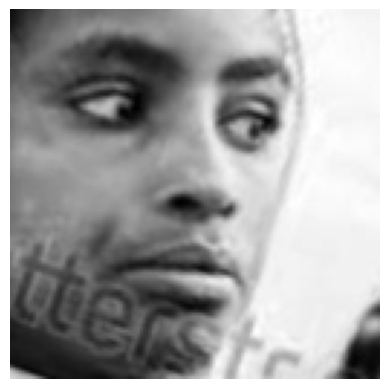

In [32]:
image_index = 3000
print("Original Gender:", gender_mapping[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_mapping[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Male Original Age: 22
1/1 [==============================] - 0s 37ms/step
Predicted Gender: Male Predicted Age: 23


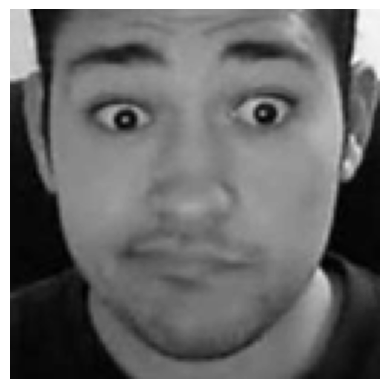

In [33]:
image_index = 500
print("Original Gender:", gender_mapping[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_mapping[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');